In [1]:
import pandas as pd
import spacy

In [2]:
labels = ['Quantity', 'Unit', 'Food', 'Variety', 'Preparation', 'Alteration', 'Brand', 'Optional', 'State']

In [3]:
ner_ds = pd.read_json("../data/NER_data/first_test.jsonl", lines=True)

In [4]:
ner_ds.head()

,id,text,label,Comments
0,2101,5 ounces rum\n4 ounces triple sec\n3 ounces Ti...,"[[0, 1, Quantity], [2, 8, Unit], [9, 12, Food]...",[]
1,2102,"2 tubes cinnamon roll, refrigerated, with icin...","[[0, 1, Quantity], [2, 7, Unit], [8, 21, Food]...",[]
2,2103,4 ripe coconuts\n1 cup evaporated milk\n1 cup ...,"[[0, 1, Quantity], [2, 6, Variety], [7, 15, Fo...",[]
3,2104,1 sheet graham cracker (broken in half)\n2 pie...,"[[0, 1, Quantity], [2, 7, Unit], [8, 22, Food]...",[]
4,2105,1 (8 ounce) package crescent rolls\n8 slices d...,"[[0, 1, Quantity], [3, 4, Quantity], [5, 10, U...",[]


In [5]:
for i, t in ner_ds[['text', 'label']].iterrows():
    print(t['text'], t['label'])

5 ounces rum
4 ounces triple sec
3 ounces Tia Maria
20 ounces orange juice
 [[0, 1, 'Quantity'], [2, 8, 'Unit'], [9, 12, 'Food'], [13, 14, 'Quantity'], [15, 21, 'Unit'], [22, 32, 'Food'], [33, 34, 'Quantity'], [35, 41, 'Unit'], [42, 51, 'Food'], [52, 54, 'Quantity'], [55, 61, 'Unit'], [62, 74, 'Food']]
2 tubes cinnamon roll, refrigerated, with icing
4 tablespoons butter, melted
6 eggs
½ cup milk
2 teaspoons cinnamon
2 teaspoons vanilla
1 cup maple syrup
 [[0, 1, 'Quantity'], [2, 7, 'Unit'], [8, 21, 'Food'], [23, 35, 'Alteration'], [42, 47, 'Food'], [48, 49, 'Quantity'], [50, 61, 'Unit'], [62, 68, 'Food'], [70, 76, 'Alteration'], [77, 78, 'Quantity'], [79, 83, 'Food'], [84, 85, 'Quantity'], [86, 89, 'Unit'], [90, 94, 'Food'], [95, 96, 'Quantity'], [97, 106, 'Unit'], [107, 115, 'Food'], [116, 117, 'Quantity'], [118, 127, 'Unit'], [128, 135, 'Food'], [136, 137, 'Quantity'], [138, 141, 'Unit'], [142, 153, 'Food']]
4 ripe coconuts
1 cup evaporated milk
1 cup gin
3 tablespoons sugar (optiona

In [6]:
from spacy.tokens import DocBin

nlp = spacy.blank("en")

def doc_from_ds(ds):
    db = DocBin()
    for i, [text, annotations] in ds[['text', 'label']].iterrows():
        try:
            doc = nlp.make_doc(text)
            entities = [doc.char_span(*annotation) for annotation in annotations]
            doc.ents = entities
            db.add(doc)
        except TypeError:
            continue
    return db
    

In [7]:
train_len = int(0.8*len(ner_ds))
train_ds = ner_ds[:train_len]
val_ds = ner_ds[train_len:]

In [8]:
train_bin = doc_from_ds(train_ds)
val_bin = doc_from_ds(val_ds)

In [9]:
train_bin

In [ ]:
train_bin.to_disk("../data/NER_data/spacy/test_train.spacy")
val_bin.to_disk("../data/NER_data/spacy/test_val.spacy")

In [83]:
BASE_CONFIG = """[paths]
train = ../data/NER_data/spacy/test_train.spacy
dev = ../data/NER_data/spacy/test_val.spacy
vectors = null
[system]
gpu_allocator = null

[nlp]
lang = "en"
pipeline = ["tok2vec","ner"]
batch_size = 1000

[components]

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${components.tok2vec.model.encode.width}
attrs = ["NORM", "PREFIX", "SUFFIX", "SHAPE"]
rows = [5000, 1000, 2500, 2500]
include_static_vectors = false

[components.tok2vec.model.encode]
@architectures = "spacy.MaxoutWindowEncoder.v2"
width = 96
depth = 4
window_size = 1
maxout_pieces = 3

[components.ner]
factory = "ner"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = true
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.optimizer]
@optimizers = "Adam.v1"

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2

[training.batcher.size]
@schedules = "compounding.v1"
start = 100
stop = 1000
compound = 1.001

[initialize]
vectors = ${paths.vectors}
"""

with open("base_config.cfg", 'w') as f:
  f.write(BASE_CONFIG)

In [84]:
!python -m spacy init fill-config base_config.cfg config_eff.cfg

✔ Auto-filled config with all values
✔ Saved config
config_eff.cfg
You can now add your data and train your pipeline:
python -m spacy train config_eff.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [85]:
!python -m spacy train config_eff.cfg --output output_eff

ℹ Saving to output directory: output_eff
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     40.66   24.12   19.36   31.98    0.24
  5     200        409.23   4610.77   82.52   81.46   83.60    0.83
 11     400        282.43    954.72   84.04   83.87   84.21    0.84
 20     600        185.25    336.01   84.47   84.73   84.21    0.84
 30     800        218.40    256.69   82.04   80.91   83.20    0.82
 43    1000        182.05    159.35   83.88   82.01   85.83    0.84
 59    1200        231.20    127.47   83.65   82.90   84.41    0.84
 79    1400        208.22    108.85   83.43   82.28   84.62    0.83
103    1600        343.36  

In [82]:
!ls ../data/NER_data/spacy

test_train.spacy  test_val.spacy


In [87]:
# load the model and test set. Again, change the paths as required
nlp = spacy.load('output_eff/model-best')
test_set = list(DocBin().from_disk("../data/NER_data/spacy/test_val.spacy").get_docs(nlp.vocab))

In [88]:
pred_ents = []
true_ents = []

for recipe in test_set:
  # tok.ent_type_ gets the ent per token, as opposed to breaking the Doc into
  # entities. This ensures that `true_ents` and `pred_ents` are the same length.
  true_ents += [tok.ent_type_ for tok in recipe]
  # `recipe.text` grabs the raw recipe, because `recipe` already contains entity
  # labels.
  pred_ents += [tok.ent_type_ for tok in nlp(recipe.text)]

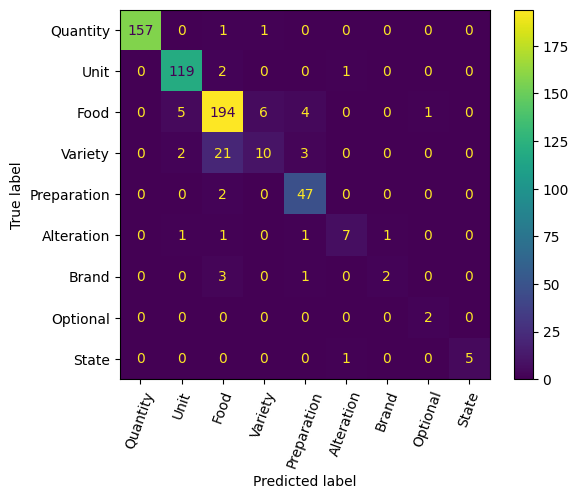

In [95]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# create and display the confusion matrix
cm = confusion_matrix(true_ents, pred_ents, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot()
plt.xticks(rotation=70)
plt.show()

### Testing on real data

In [96]:
nlg_ds = pd.read_csv('../data/recipenlg/RecipeNLG_dataset.csv', converters={'ingredients': pd.eval}, nrows=5)


In [107]:
nlg_ds.head()
ingredient_texts = []
for ingredient in nlg_ds['ingredients']:
    ingredient_texts.append(nlp("\n".join(ingredient)))

In [97]:
from spacy import displacy

In [108]:
displacy.render(ingredient_texts, style='ent', jupyter=True)